In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

from pathlib import Path
from wordcloud import WordCloud
import re
import string
import spacy
from collections import Counter

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/domenjemec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def get_text(text_file):
    cols_to_select = ['bbid','featureexplanation','businesspurpose','altsolutions','followup']
    text_cols= ['featureexplanation','businesspurpose','altsolutions']
    df = pd.read_csv(csv_file, usecols= cols_to_select).dropna(subset=
        text_cols, how='all').replace(np.nan, '', regex=True)
    df['text'] = 'featureexplanation: ' + df['featureexplanation'] \
    + '/n businesspurpose: ' + df['featureexplanation'] \
    + '/n altsolutions: ' + df['altsolutions']
    df = df.drop(text_cols,axis=1)
    df.columns = ['bbid','labels','text']
    return df

def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def process_text(text):
    # convert text to lowercase
    text = text.lower()
    # sub common symbols and remove non-ascii chars
    test = text.replace('/',' andor ')
    text = text.replace('&',' and ')
    text = text.replace('£','$ ')
    text = re.sub(r'[ ]{2,}',' ',text)
    text = re.sub(r'[.]{2,}',' ',text)
    text = text.encode("ascii", errors="ignore").decode()
    # remove all punctuation except apostrophes and dollar sign
    text = re.sub(r"[^\w\s'\$]",'',text)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    # remove stop words
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # stem words
    stemmer = SnowballStemmer("english")
    stemmed_text = ''
    for word in text.split():
            stemmed_text += (stemmer.stem(word))+' '
    text = stemmed_text
    return text

def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y,yhat),4))
    print('precision: ', round(precision_score(y,yhat),4))
    print('recall: ', round(recall_score(y,yhat),4))
    print('f1: ', round(f1_score(y,yhat),4))
    print('auc: ', round(roc_auc_score(y,yhat),4))
    print('confusion matrix:\n', confusion_matrix(y,yhat))

def plot_feature_importances(model,vectorizer,max_num=10):
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    top_importances = -np.sort(-model.feature_importances_)[:max_num]
    top_importances = np.sort(top_importances)
    top_features = np.argsort(-model.feature_importances_)[:max_num]
    #top_features = np.sort(top_features)
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()

In [3]:
out_dir = './PROCESSED_DATA'
text_path = './RAW_DATA/'
text_name = 'labeled_set.csv'
csv_file = Path(text_path+text_name)
df = get_text(csv_file)
df.head(10)

,bbid,labels,text
13,633,1,featureexplanation: A number of features this ...
200,1141,0,featureexplanation: Spent time modifying exist...
265,1153,0,featureexplanation: Spent a lot of time modify...
266,186,0,featureexplanation: Multiple related action to...
373,1051,0,featureexplanation: Few database views were ve...
374,631,0,featureexplanation: V3.1 release/n businesspur...
439,116,0,featureexplanation: New solution for BH is in ...
442,1207,0,featureexplanation: Was updating exception sce...
451,722,0,featureexplanation: Spent a lot of time creati...
459,1139,0,featureexplanation: Our team spends a signific...


see the pk to eventually connect back to the core set, a binary label, and a concatenated text field to help group together the 3 different text fields

In [4]:
print('number of followup: ',len(df[df.labels==1]))
print('number of non-followup: ',len(df[df.labels==0]))
print('number of total comments: ', len(df))

number of followup:  33
number of non-followup:  60
number of total comments:  93


followup wordcloud


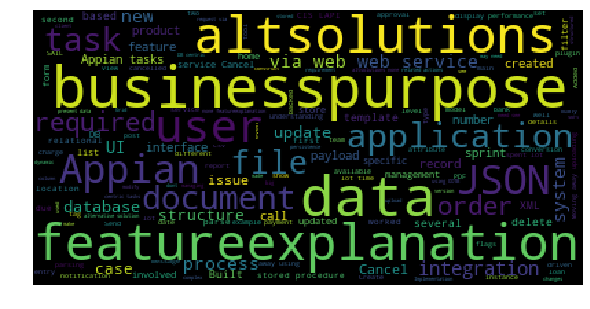

non-followup wordcloud


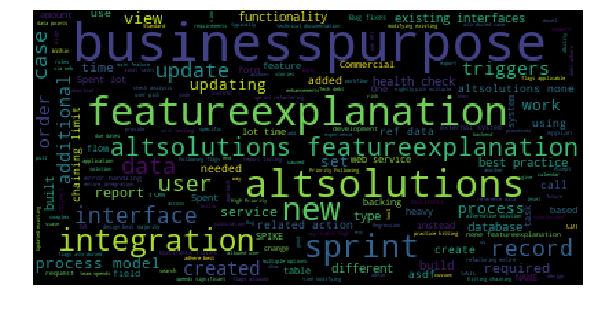

In [5]:
print('followup wordcloud')
spams = df.text[df.labels==1]
show_wordcloud(spams)

print('non-followup wordcloud')
nonspams = df.text[df.labels==0]
show_wordcloud(nonspams)

In [6]:
df['text_processed'] = df.text.apply(process_text)
df.head(10)

,bbid,labels,text,text_processed
13,633,1,featureexplanation: A number of features this ...,featureexplan number featur sprint involv upda...
200,1141,0,featureexplanation: Spent time modifying exist...,featureexplan spent time modifi exist interfac...
265,1153,0,featureexplanation: Spent a lot of time modify...,featureexplan spent lot time modifi exist inte...
266,186,0,featureexplanation: Multiple related action to...,featureexplan multipl relat action progress re...
373,1051,0,featureexplanation: Few database views were ve...,featureexplan databas view slow queri call hea...
374,631,0,featureexplanation: V3.1 release/n businesspur...,featureexplan v31 releasen businesspurpos v31 ...
439,116,0,featureexplanation: New solution for BH is in ...,featureexplan new solut bh work work commerci ...
442,1207,0,featureexplanation: Was updating exception sce...,featureexplan updat except scenario regard can...
451,722,0,featureexplanation: Spent a lot of time creati...,featureexplan spent lot time creat process mod...
459,1139,0,featureexplanation: Our team spends a signific...,featureexplan team spend signific portion deve...


In [7]:
bblock = df.iloc[5]
doc = bblock.text_processed.split(' ')
[token for token in doc]

['featureexplan',
 'v31',
 'releasen',
 'businesspurpos',
 'v31',
 'releasen',
 'altsolut',
 '']

In [8]:
nlp = spacy.load('en_core_web_sm')
bblock = df.iloc[5]
doc = nlp(bblock.text_processed)
[token.text for token in doc]

['featureexplan',
 'v31',
 'releasen',
 'businesspurpos',
 'v31',
 'releasen',
 'altsolut']

In [9]:
nlp = spacy.load('en_core_web_sm')
df['tokens'] = df.text_processed.apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))
df.head(10)

,bbid,labels,text,text_processed,tokens
13,633,1,featureexplanation: A number of features this ...,featureexplan number featur sprint involv upda...,featureexplan number featur sprint involv upda...
200,1141,0,featureexplanation: Spent time modifying exist...,featureexplan spent time modifi exist interfac...,featureexplan spent time modifi exist interfac...
265,1153,0,featureexplanation: Spent a lot of time modify...,featureexplan spent lot time modifi exist inte...,featureexplan spent lot time modifi exist inte...
266,186,0,featureexplanation: Multiple related action to...,featureexplan multipl relat action progress re...,featureexplan multipl relat action progress re...
373,1051,0,featureexplanation: Few database views were ve...,featureexplan databas view slow queri call hea...,featureexplan databas view slow queri call hea...
374,631,0,featureexplanation: V3.1 release/n businesspur...,featureexplan v31 releasen businesspurpos v31 ...,featureexplan v31 releasen businesspurpos v31 ...
439,116,0,featureexplanation: New solution for BH is in ...,featureexplan new solut bh work work commerci ...,featureexplan new solut bh work work commerci ...
442,1207,0,featureexplanation: Was updating exception sce...,featureexplan updat except scenario regard can...,featureexplan updat except scenario regard can...
451,722,0,featureexplanation: Spent a lot of time creati...,featureexplan spent lot time creat process mod...,featureexplan spent lot time creat process mod...
459,1139,0,featureexplanation: Our team spends a signific...,featureexplan team spend signific portion deve...,featureexplan team spend signific portion deve...


In [10]:
vocab_list = ' '.join(t for t in df.tokens).split(' ')
counts = Counter(vocab_list)

print('top words','\t','count')
print('----------------------')
for word,count in counts.most_common(20):
    print(word,'\t\t',count)

top words 	 count
----------------------
featureexplan 		 93
businesspurpos 		 93
altsolut 		 93
data 		 67
user 		 45
updat 		 43
n 		 40
integr 		 40
process 		 37
creat 		 36
task 		 35
servic 		 35
new 		 34
sprint 		 32
requir 		 32
interfac 		 29
appian 		 29
order 		 28
use 		 28
case 		 26


In [11]:
cv = CountVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words='english',max_features=30)
#cv = CountVectorizer(preprocessor=process_text, tokenizer=nlp.tokenizer, ngram_range=(1,2),max_features=2000)
X_counts = cv.fit_transform(df.tokens)
y = df.labels
print(X_counts.shape,y.shape)

(93, 30) (93,)


In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_counts, y, test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [13]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy:  0.5263
precision:  0.5
recall:  0.4444
f1:  0.4706
auc:  0.5222
confusion matrix:
 [[6 4]
 [5 4]]


In [14]:
tfidf = TfidfVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words='english',max_features=30)
X_tfidf = tfidf.fit_transform(df.text_processed)
y = df.labels
print(X_tfidf.shape,y.shape)

(93, 30) (93,)


In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, y, test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

In [16]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy:  0.5789
precision:  0.5
recall:  0.25
f1:  0.3333
auc:  0.5341
confusion matrix:
 [[9 2]
 [6 2]]


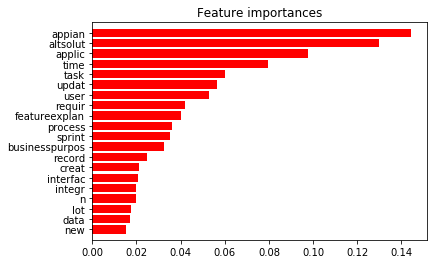

In [18]:
plot_feature_importances(model,tfidf, 20)